In [11]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator
from pitchfuncs import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time

In [12]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [13]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]
model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
2914018,0.94,0.012797,0.28,2.1,4.995611,0.965106,0.938551,5787.040737,0.011533,695.525323,...,0.752593,0.753473,0.754441,0.753786,0.754619,0.755015,0.754488,0.752885,0.750709,0.749057


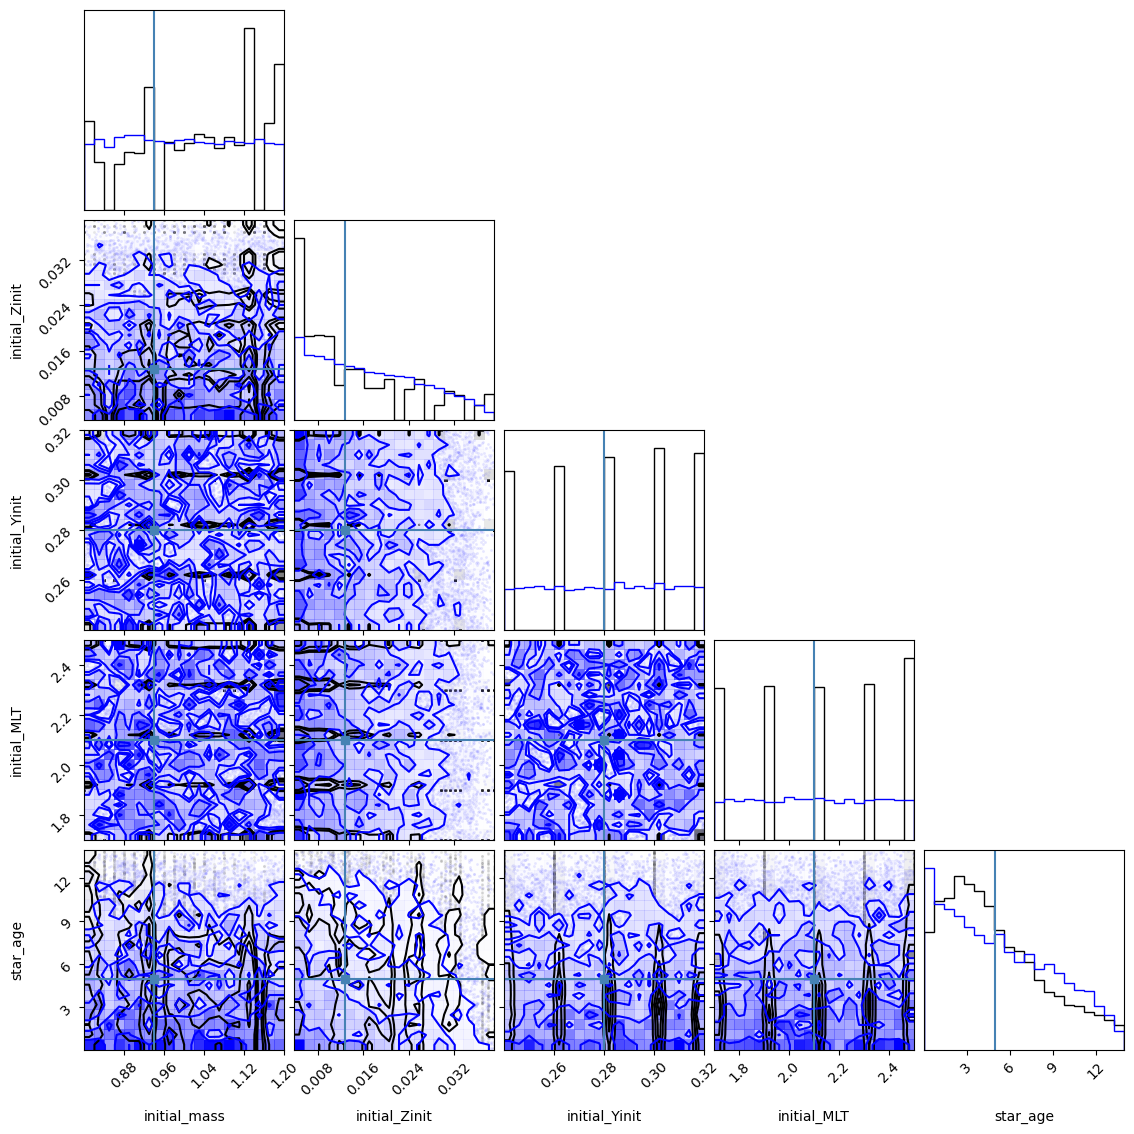

In [80]:
"""
Define priors
"""

def grid_uniform_prior(df, header):
    df_min = df[header].min()
    return scipy.stats.uniform(loc=df_min, scale=df[header].max()-df_min)

def uniform_prior(model_inps, header, scale=0.1):
    model_min = model_inps[header]*(1-scale)
    return scipy.stats.uniform(loc=model_min, scale=(model_inps[header]*(1+scale))-model_min)

def normal_prior(model_inps, header, scale=0.1):
    loc=model_inps[header].values[0]
    return scipy.stats.norm(loc=loc, scale=scale*loc)

def beta_prior(df, header,a=1,b=1):
    df_min = df[header].min()
    return scipy.stats.beta(loc=df_min, scale=df[header].max()-df_min, a=a, b=b)

mass_prior = grid_uniform_prior(df, "initial_mass")

Zinit_prior = beta_prior(df,"initial_Zinit",a=0.9, b=1.5)

Yinit_prior = grid_uniform_prior(df, "initial_Yinit")

MLT_prior = grid_uniform_prior(df, "initial_MLT")

age_prior = beta_prior(df, "star_age", a=0.9, b=1.5)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000), hist_kwargs={'density':True});

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure,hist_kwargs={'density':True});

In [81]:
pitchfork = emulator("nu6-40_elu_nonorm")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [82]:
"""
Define observed quantities and uncertainties
"""
obs = model_outs.values[0]
unc = np.array([0.007, 0.015, 0.0001] + [4 + 0.01*(np.abs(i-22))**2 for i in range(5,40)])

iter: 16885 | +1000 | bound: 89 | nc: 1 | ncall: 368404 | eff(%):  4.868 | loglstar:   -inf < -72.636 <    inf | logz: -89.608 +/-    nan | dlogz:  0.001 >  1.009                                    

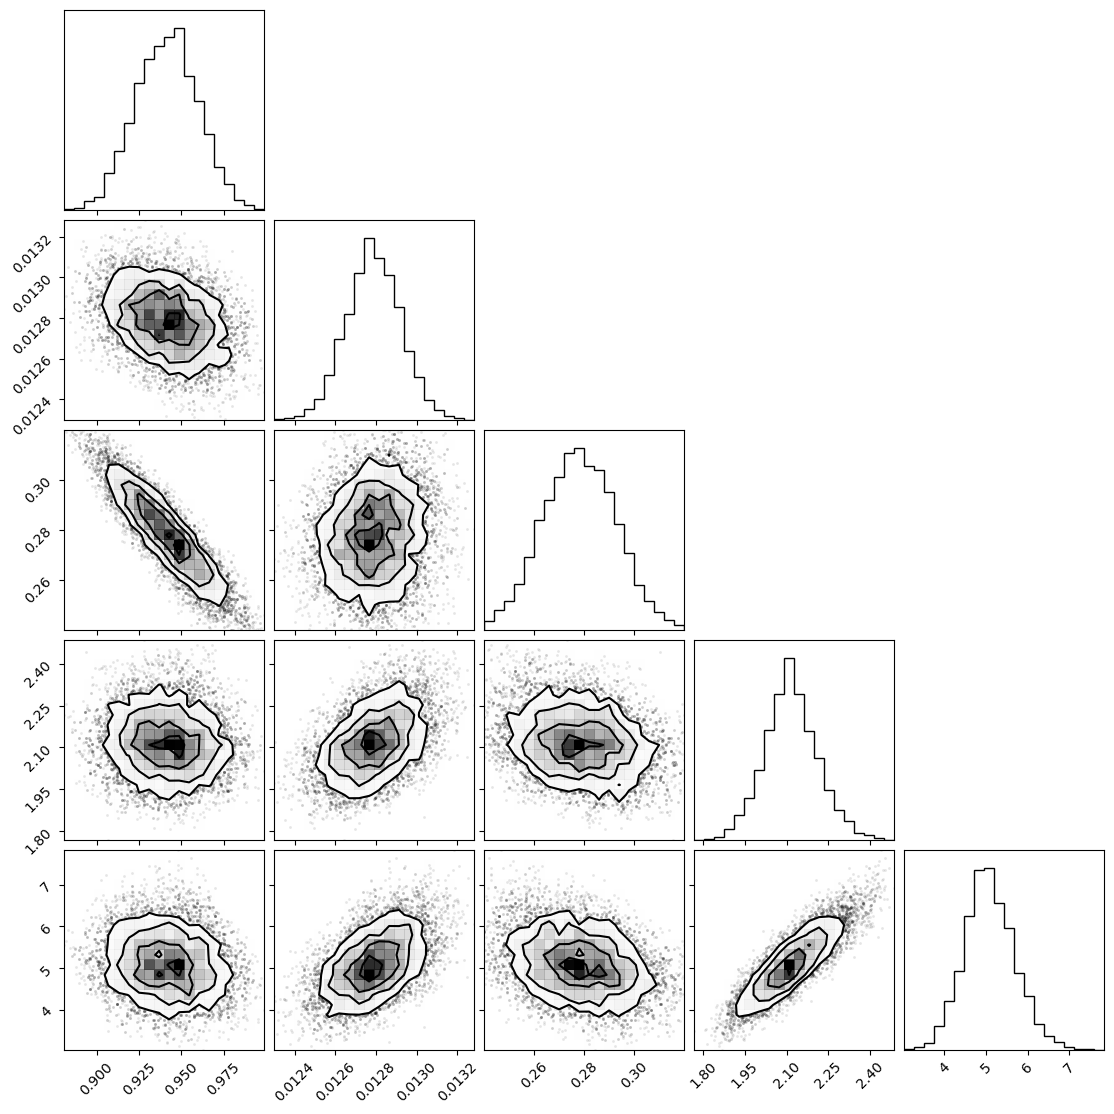

In [83]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler(nlive=1000)
toc = time.time()

corner.corner(posterior);

1345.1412661075592


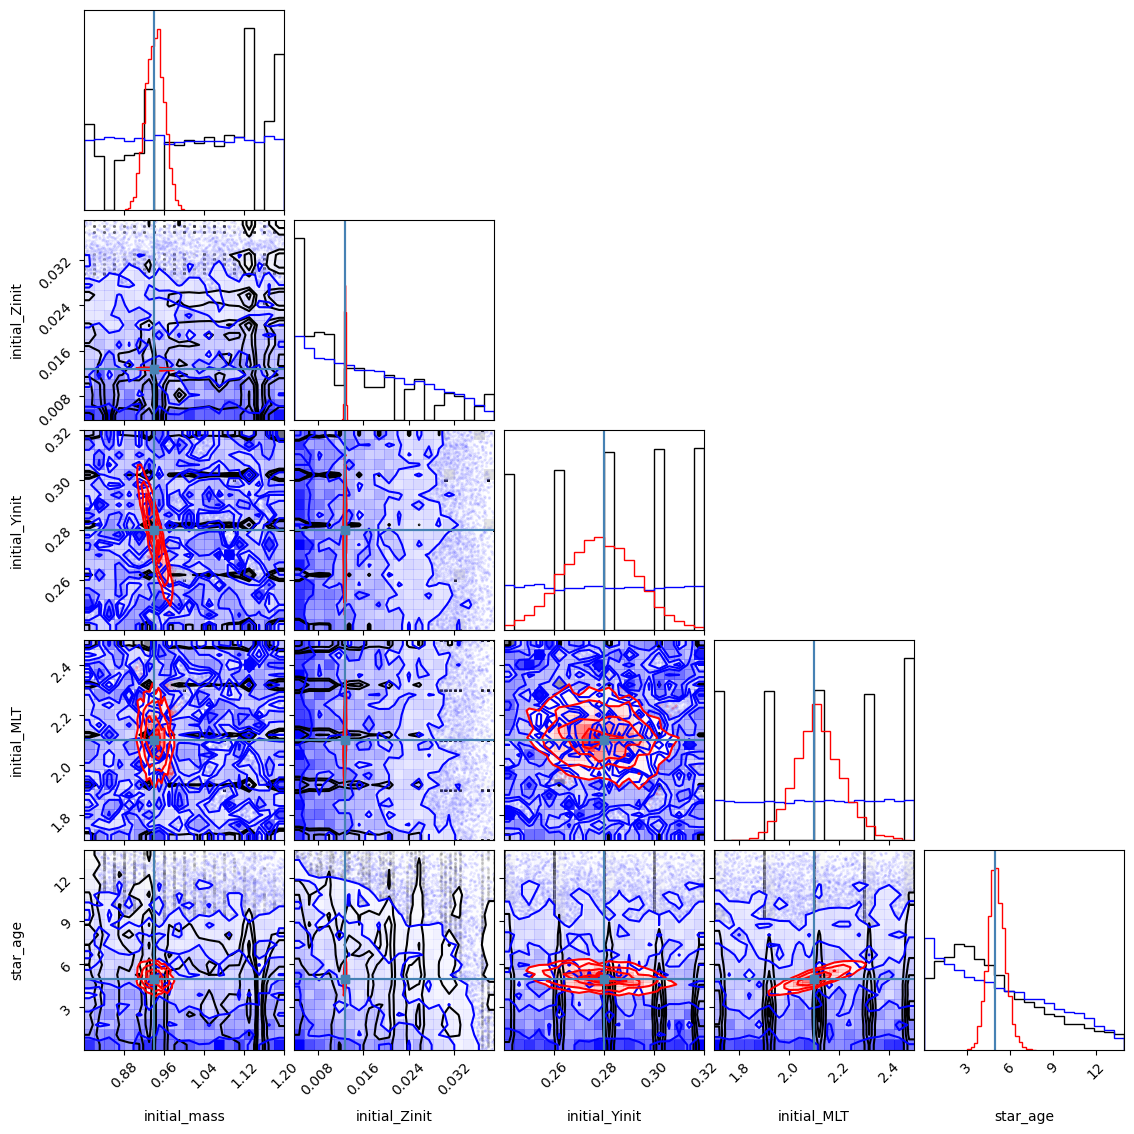

In [84]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));
print(toc-tic)
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

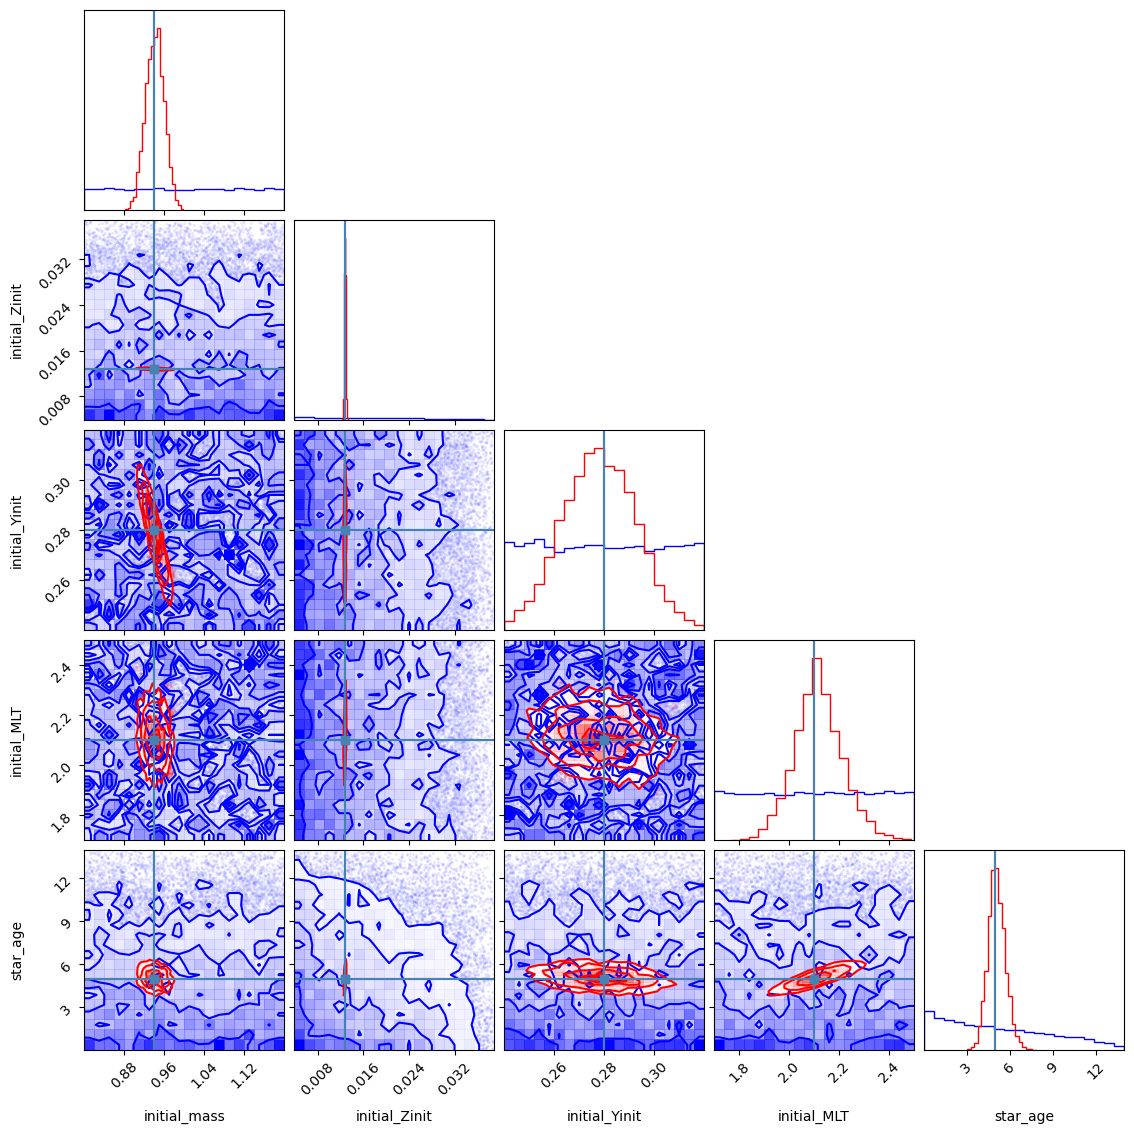

In [86]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

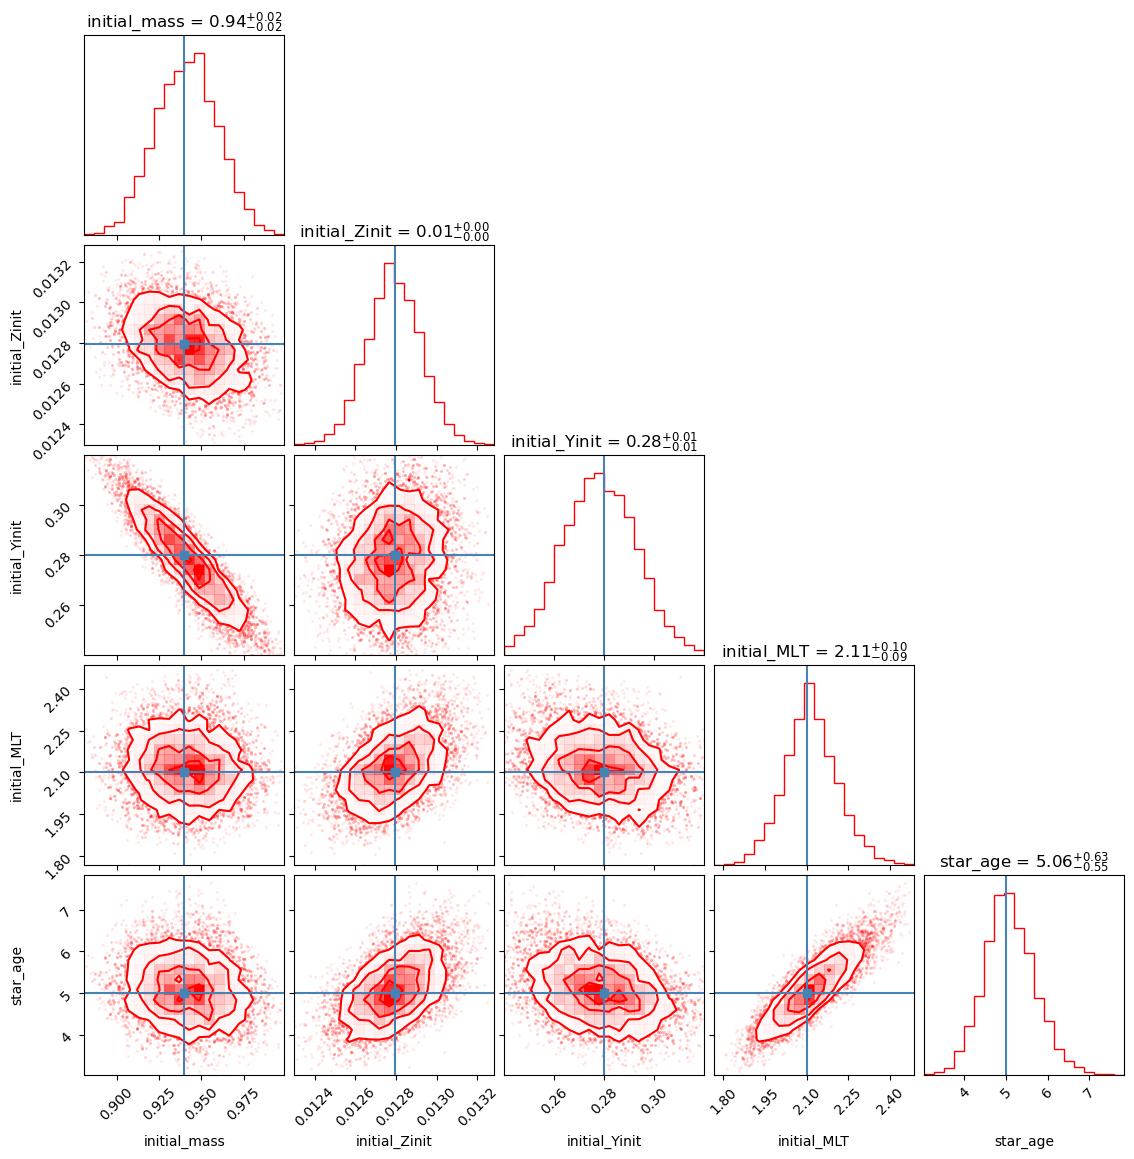

In [87]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True);

In [19]:
%timeit pitchfork.predict([[0,0,0,0,0]])

12.9 ms ± 47.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
import pickle
file_path = "pickle jar/nu6-40_elu"

with open(file_path+".pkl", 'rb') as fp:
    emulator_dict = pickle.load(fp)
    
custom_objects = {"InversePCA": InversePCA(emulator_dict['custom_objects']['inverse_pca']['pca_comps'], emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(emulator_dict['custom_objects']['WMSE']['weights'])}

model = tf.keras.models.load_model(file_path+".h5", custom_objects=custom_objects)

In [18]:
%timeit model.predict([[0,0,0,0,0]])

1/1 [==============================] - 0s 21ms/step
44.4 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
